Valid:
* TOB3_long2
* TOB3_long3
* TOB3_long4

In [22]:
ref_tob3.iloc[::100]

,TIMESTAMP,text_val,temp_Avg(1),temp_Avg(2),temp_Avg(3),temp_Max(1),temp_TMx(1),temp(1),temp(2),temp(3),temp(4),temp(5),text_val_2,toggle,temp_bool8(1),temp_bool8(2),temp(8),rand,text_val_3
RECORD,,,,,,,,,,,,,,,,,,,
2571.0,1.771494e+18,64291.0,NaN,NaN,0.0,NaN,1.771494e+18,-0.400,0.400011,0.0,62954.0,12849000.0,142857.0,0.0,11111111.0,11111111.0,0.0,-0.400011,314159.0
2671.0,1.771494e+18,64291.0,NaN,NaN,0.0,NaN,1.771494e+18,1.251,-1.251255,0.0,2378.0,13345000.0,142857.0,-1.0,11111111.0,11111111.0,0.0,1.251255,314159.0


In [1]:
from unittest import TestCase
from math import ceil
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import camp2ascii.formats as fmt
from camp2ascii import camp2ascii

fmt.REPAIR_MISALIGNED_MINOR_FRAMES = False


parent = Path("/home/alextsfox/git-repos/camp2ascii/tests")

in_dir = parent / "raw"

out_dir = parent / "c2a"
out_dir.mkdir(parents=True, exist_ok=True)

# fig, axs = plt.subplots(ceil(20/2), 2, figsize=(12, 15), sharex=True)
try:
    out_files = camp2ascii(in_dir, out_dir, pbar=True, verbose=3)
    for f in out_files:
        file_type = re.search(r"TOB\d", f.name).group(0)

        my_tob3 = pd.read_csv(f, skiprows=[0, 2, 3], na_values=["NAN", '"NAN"'])
        my_tob3["TIMESTAMP"] = pd.to_datetime(my_tob3["TIMESTAMP"], format="ISO8601")

        ref_file = list((out_dir.parent / "cc").glob(f"*{f.stem}*"))[0]
        ref_tob3 = pd.read_csv(ref_file, skiprows=[0, 2, 3], na_values=["NAN", '"NAN"'])
        ref_tob3["TIMESTAMP"] = pd.to_datetime(ref_tob3["TIMESTAMP"], format="ISO8601")

        if "temp_TMx(1)" in ref_tob3.columns:
            ref_tob3["temp_TMx(1)"] = pd.to_datetime(ref_tob3["temp_TMx(1)"], format="ISO8601")
            my_tob3["temp_TMx(1)"] = pd.to_datetime(my_tob3["temp_TMx(1)"], format="ISO8601")
        
        for col in ref_tob3.columns:
            if col in {"TIMESTAMP", "temp_TMx(1)"}:
                ref_tob3[col] = ref_tob3[col].astype(np.int64)
                my_tob3[col] = my_tob3[col].astype(np.int64)
            ref_tob3[col] = ref_tob3[col].astype(np.float64)
            my_tob3[col] = my_tob3[col].astype(np.float64)

        ref_tob3 = ref_tob3.set_index("RECORD")
        my_tob3 = my_tob3.set_index("RECORD")


        common_idx = ref_tob3.index.union(my_tob3.index)
        if file_type == "TOB3" and ref_tob3["TIMESTAMP"].diff().diff().abs().max() > 1e5:  # 100us
            common_idx = ref_tob3.index.intersection(my_tob3.index)
        ref_tob3 = ref_tob3.loc[common_idx].sort_index()
        my_tob3 = my_tob3.loc[common_idx].sort_index()

        print(np.allclose(ref_tob3, my_tob3, equal_nan=True))
finally:
    for f in out_files:
        f.unlink(missing_ok=True)

Processing files:  31%|███▏      | 221k/708k [00:00<00:00, 1.08MB/s] 

huh?
huh?
huh?
huh?
huh?
huh?


Processing files:  61%|██████    | 430k/708k [00:00<00:00, 1.04MB/s]

huh?
huh?
huh?
huh?
huh?
huh?


Processing files:  87%|████████▋ | 615k/708k [00:00<00:00, 954kB/s] 

huh?
huh?
huh?
huh?
huh?
huh?


Processing files: 865kB [00:00, 999kB/s]                           

huh?
huh?
huh?
huh?
huh?
huh?


Processing files: 100%|██████████| 708k/708k [00:01<00:00, 650kB/s]

huh?
huh?
huh?
huh?


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [19]:
from pathlib import Path
from typing import Literal
import re
import csv

import numpy as np
import pandas as pd
from pandas.api.types import pandas_dtype

from camp2ascii.headers import parse_file_header
from camp2ascii.formats import FileType
from camp2ascii.decode import FINAL_TYPES

def toa5_to_pandas(
    path: str | Path, 
    index:Literal["TIMESTAMP", "RECORD"] | None = "TIMESTAMP", 
    sort_index: bool = True,
    na_values=["NAN", '"NAN"', "-9999"],
    int_na_fill_value: int = -9999,
    try_to_parse_dates: bool = True,
) -> pd.DataFrame:
    """
    Reads a TOA5 file into a pandas dataframe.

    Parameters
    ----------
    path : str | Path
        Path to the TOA5 file.
    index : "TIMESTAMP" | "RECORD" | None, optional
        Column to set as index. If None, the dataframe will not have an index column.
    sort_index : bool, optional
        Whether to sort the dataframe by the index after setting it. Default is True.
    na_values : list, optional
        List of values in the file to interpret as NaN. Default is ["NAN", '"NAN"', "-9999"].
    int_na_fill_value : int, optional
        Fill value to use in the returned dataframe for integer columns that contain NaNs.
    try_to_parse_dates : bool, optional
        Whether to attempt to parse any columns that look like timestamps as datetime objects. Default is True.
    """



    with open(path, "rb") as input_buff:
        header, header_nbytes = parse_file_header(input_buff, path)

        if header.file_type != FileType.TOA5:
            raise TypeError(f"File {path} is not a TOA5 file")

        input_buff.seek(header_nbytes)
        reader = csv.reader((line.decode('ascii') for line in input_buff), delimiter=',', quotechar="'")
        cols_parsed = 0
        dtypes = {n: None for n in header.names}
        
        for line in reader:
            for i, val in enumerate(line):
                if dtypes[header.names[i]] is not None:
                    continue
                if ('"' in val) and ('"NAN"' not in val):
                    dtypes[header.names[i]] = "str"
                elif ("e" in val) or ("." in val) or ("E" in val) or ("+" in val):
                    dtypes[header.names[i]] = "float"
                elif val != '"NAN"':
                    dtypes[header.names[i]] = "int"
            # exit the loop once we've parsed all the columns
            if cols_parsed == len(header.names):
                break
        # all nans: parse as float
        for i, col in enumerate(dtypes):
            if dtypes[col] is None:
                dtypes[col] = "float"
                

    df = pd.read_csv(
        path, 
        skiprows=[0, 2, 3], 
        na_values=na_values, 
        # int can't be nan, so we temporarily parse them as floats before recasting them to ints
        dtype={name: typ.replace("int", "float") for name, typ in dtypes.items()}
    )
    for name, typ in dtypes.items():
        if typ == "int":
            df[name] = df[name].replace(np.nan, int_na_fill_value).astype(int)

                
    if try_to_parse_dates:
        for col in df.select_dtypes(exclude=[np.number]).columns:
            
            # try to parse known timestamp columns first
            proc = header.processing[header.names.index(col)] if col in header.names else None
            if proc.upper() in {"TS", "TMX", "TMN"}:
                df[col] = pd.to_datetime(df[col], format="ISO8601", errors="coerce")
                continue

            # the column may not be a timestamp, but it might still be parseable as one.
            for i in range(df.shape[0]):
                val = df.at[i, col]
                if val == np.nan:
                    continue
                if re.match(r"[12]\d{3}-\d{2}-\d{2}", val) is not None:
                    df[col] = pd.to_datetime(df[col], format="ISO8601")
                # quit as soon as we fail to parse a non-na value
                break

    if index not in df.columns:
        raise ValueError(f"Index column {index} not found in {path.relative_to(path.parent.parent.parent)} columns.")
    if index is not None and index in df.columns:
        df.set_index(index, inplace=True)
        if sort_index:
            df.sort_index(inplace=True)
    
    return df
df = toa5_to_pandas("/home/alextsfox/git-repos/camp2ascii/tests/cc/TOA5_TOB3_long21_2026_02_19_0946.dat")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2026-02-19 09:46:11.005000 to 2026-02-19 09:46:12
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RECORD         200 non-null    int64  
 1   text_val       200 non-null    object 
 2   temp_Avg(1)    0 non-null      float64
 3   temp_Avg(2)    0 non-null      float64
 4   temp_Avg(3)    0 non-null      float64
 5   temp(1)        171 non-null    float64
 6   temp(2)        200 non-null    float64
 7   temp(3)        200 non-null    float64
 8   temp(4)        200 non-null    int64  
 9   temp(5)        200 non-null    int64  
 10  text_val_2     200 non-null    object 
 11  toggle         200 non-null    int64  
 12  temp_bool8(1)  200 non-null    object 
 13  temp_bool8(2)  200 non-null    object 
 14  temp(8)        200 non-null    int64  
 15  rand           200 non-null    float64
 16  text_val_3     200 non-null    object 
dtypes: float64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2026-02-19 09:46:11.005000 to 2026-02-19 09:46:12
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RECORD         200 non-null    int64  
 1   text_val       200 non-null    object 
 2   temp_Avg(1)    200 non-null    int64  
 3   temp_Avg(2)    200 non-null    int64  
 4   temp_Avg(3)    200 non-null    int64  
 5   temp(1)        171 non-null    float64
 6   temp(2)        200 non-null    float64
 7   temp(3)        200 non-null    float64
 8   temp(4)        200 non-null    int64  
 9   temp(5)        200 non-null    int64  
 10  text_val_2     200 non-null    object 
 11  toggle         200 non-null    int64  
 12  temp_bool8(1)  200 non-null    object 
 13  temp_bool8(2)  200 non-null    object 
 14  temp(8)        200 non-null    int64  
 15  rand           200 non-null    float64
 16  text_val_3     200 non-null    object 
dtypes: float64

In [162]:
# find the sum of absolute differences
print((ref_tob3.iloc[:my_tob3.shape[0], 0].fillna(0) - my_tob3.iloc[:, 0].fillna(0)).abs().sum())

# convert to float arrays and compare with equal_nan
ref_arr = ref_tob3.iloc[:my_tob3.shape[0], 0].to_numpy(dtype=float)
my_arr = my_tob3.iloc[:, 0].to_numpy(dtype=float)
close_mask = np.isclose(ref_arr, my_arr, equal_nan=True)
print(close_mask.all())
print("mismatches", (~close_mask).sum())

# check if difference is 0
print(0 == (ref_tob3.iloc[:my_tob3.shape[0], 0].fillna(0) - my_tob3.iloc[:, 0].fillna(0)).abs().sum())

# allclose with equal_nan
print(np.allclose(ref_arr, my_arr, equal_nan=True))

0.0
False
mismatches 134
True
False


(TIMESTAMP
 2026-02-18 11:38:19.200    145
 2026-02-18 11:38:19.400    146
 2026-02-18 11:38:19.600    147
 2026-02-18 11:38:19.800    148
 2026-02-18 11:38:20.000    149
                           ... 
 2026-02-18 11:38:00.200     45
 2026-02-18 11:38:00.400     46
 2026-02-18 11:38:00.600     47
 2026-02-18 11:38:00.800     48
 2026-02-18 11:38:01.000     49
 Name: RECORD, Length: 134, dtype: int64,
 TIMESTAMP
 2026-02-18 11:38:20.200    150
 2026-02-18 11:38:20.400    151
 2026-02-18 11:38:20.600    152
 2026-02-18 11:38:20.800    153
 2026-02-18 11:38:21.000    154
                           ... 
 2026-02-18 11:38:35.000    224
 2026-02-18 11:38:35.200    225
 2026-02-18 11:38:35.400    226
 2026-02-18 11:38:35.600    227
 2026-02-18 11:38:35.800    228
 Name: RECORD, Length: 134, dtype: int64)

In [148]:
(ref_tob3.iloc[:my_tob3.shape[0], 0] - my_tob3.iloc[:, 0]).iloc[-5:] == 0

TIMESTAMP
2026-02-18 11:38:35.000    True
2026-02-18 11:38:35.200    True
2026-02-18 11:38:35.400    True
2026-02-18 11:38:35.600    True
2026-02-18 11:38:35.800    True
Name: RECORD, dtype: bool

array([[<Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>],
       [<Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>],
       [<Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>],
       [<Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>],
       [<Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>],
       [<Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>]],
      dtype=object)

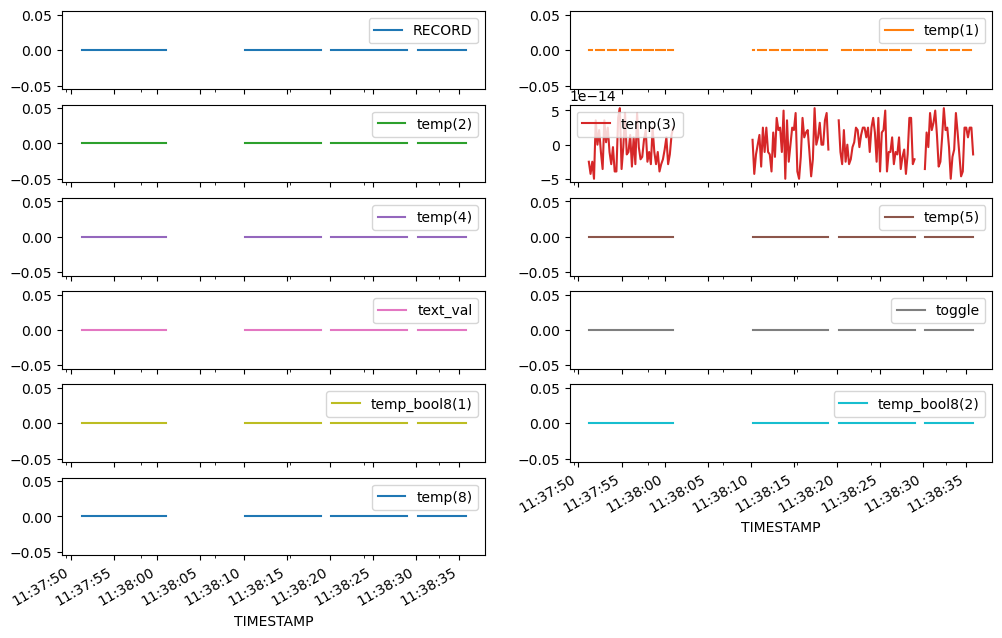

In [131]:
(ref_tob3.iloc[:my_tob3.shape[0], 0] - my_tob3).plot(subplots=True, layout=(ceil(len(ref_tob3.columns) / 2), 2), figsize=(12, 8))